In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
information_train = pd.read_csv('/home/infoobjects/Desktop/Innoplexus/information_train.csv',delimiter='\t')
train = pd.read_csv('/home/infoobjects/Desktop/Innoplexus/train.csv',delimiter=',')

In [4]:
#Fitting TFIDF Vectorizer over complete corpus
tfidf_vectorizer_title = TfidfVectorizer(analyzer='word',ngram_range=(1,3),stop_words='english',norm='l2',max_features=50)
title_vectors = tfidf_vectorizer_title.fit_transform(information_train['article_title'])

tfidf_vectorizer_abstract = TfidfVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english',norm='l2',max_features=200)
abstract_vectors = tfidf_vectorizer_abstract.fit_transform(information_train['abstract'])

In [6]:
train_set_numbers = list(information_train.set.value_counts().index)
# test_set_numbers = list(information_test.set.value_counts().index)
train_set_numbers,information_train.set.value_counts()

([16, 3, 5, 14, 8, 18, 13, 2, 6], 16    753
 3     603
 5     502
 14    410
 8     388
 18    368
 13    218
 2     173
 6     107
 Name: set, dtype: int64)

In [7]:
def get_set_wise_data(set_number):
    information_for_this_set = information_train[information_train.set == set_number]
    information_for_this_set = information_for_this_set.head(20)
    information_for_this_set.reset_index(drop=True,inplace=True)
    information_for_this_set = information_for_this_set[['abstract','article_title','pmid','pub_date']]

    return information_for_this_set

In [8]:
data_set_wise_train = {}
for each_set in train_set_numbers:
    data_set_wise_train[each_set] = get_set_wise_data(each_set)

In [9]:
data_set_wise_train[16].head()

,abstract,article_title,pmid,pub_date
0,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01
1,The aim of this study was to determine the app...,General primer-mediated polymerase chain react...,1370845,1992-01-01
2,We describe a rapid method for extraction and ...,Rapid diagnosis of enterovirus infection by ma...,8380182,1993-01-01
3,"We have developed a simple, rapid, and reliabl...",Rapid and simple method for purification of nu...,1691208,1990-03-01
4,Enteroviruses were specifically detected in cr...,Specific detection of enteroviruses in clinica...,2155917,1990-02-01


In [10]:
def merging_data_frame(particular_row_series,df_remaining_rows):
    
    duplicate_frequency = df_remaining_rows.shape[0] - 1
    df_remaining_rows = df_remaining_rows.rename(columns={'abstract': 'abstract_1', 'article_title': 'article_title_1','pmid': 'pmid_1','pub_date': 'pub_date_1'})
    df_particular_row = pd.DataFrame(particular_row_series).transpose()
    df_particular_row = df_particular_row.append([df_particular_row]*duplicate_frequency,ignore_index=True)
    

    df_particular_row.reset_index(drop=True, inplace=True)
    df_remaining_rows.reset_index(drop=True, inplace=True)

    result = pd.concat([df_particular_row, df_remaining_rows], axis=1)
    return result
#     master_frames.append(result)
    

In [11]:
combined_data_train = {}
for each_set in train_set_numbers:
    master_frames = []
    this_set_data = data_set_wise_train[each_set]
    for index,row in this_set_data.iterrows():
        master_frames.append(merging_data_frame(this_set_data.iloc[index],this_set_data.drop(this_set_data.index[[index]])))
    
    combined_df = pd.concat(master_frames,ignore_index=True)
    combined_df.pub_date = pd.to_datetime(combined_df.pub_date)
    combined_df.pub_date_1 = pd.to_datetime(combined_df.pub_date_1)
    combined_df['differnce_days'] = combined_df['pub_date'] - combined_df['pub_date_1']
    combined_df['differnce_days'] = combined_df['differnce_days'] / (np.timedelta64(1, 'D'))
    combined_df = combined_df[combined_df > 0].dropna()
    combined_df.reset_index(drop=True,inplace=True)

    combined_data_train[each_set] = combined_df


In [12]:
def cosine_similarity_abstract(row):
    
    index_1 = information_train.pmid[information_train.pmid == row['pmid']].index.tolist()[0]
    index_2 = information_train.pmid[information_train.pmid == row['pmid_1']].index.tolist()[0]
    similarity_score = cosine_similarity(abstract_vectors[index_1],abstract_vectors[index_2])
    return similarity_score[0][0]
    
def cosine_similarity_title(row):
    
    index_1 = information_train.pmid[information_train.pmid == row['pmid']].index.tolist()[0]
    index_2 = information_train.pmid[information_train.pmid == row['pmid_1']].index.tolist()[0]
    similarity_score = cosine_similarity(title_vectors[index_1],title_vectors[index_2])
    return similarity_score[0][0]

In [13]:
for each_set in train_set_numbers:
    combined_data_train[each_set]['title_similarity'] = combined_data_train[each_set].apply(cosine_similarity_title,axis=1)
    combined_data_train[each_set]['abstract_similarity'] = combined_data_train[each_set].apply(cosine_similarity_abstract,axis=1)

In [14]:
combined_data_train[16].head(2)

,abstract,article_title,pmid,pub_date,abstract_1,article_title_1,pmid_1,pub_date_1,differnce_days,title_similarity,abstract_similarity
0,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,The aim of this study was to determine the app...,General primer-mediated polymerase chain react...,1370845,1992-01-01,1766.0,0.0,0.063952
1,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,We describe a rapid method for extraction and ...,Rapid diagnosis of enterovirus infection by ma...,8380182,1993-01-01,1400.0,0.0,0.113354


In [15]:
def is_refernce(row):
    index_train = train.pmid[train.pmid == row['pmid']].index.tolist()[0]
    references_string = train.iloc[index_train]['ref_list']
    references_string_clean = references_string.replace('[','').replace(']','').replace('\'','').split(sep=',')
    references_list = list(map(int, references_string_clean))
    
    if row['pmid_1'] in references_list:
        return 1
    return 0

In [16]:
for each_set in train_set_numbers:
    combined_data_train[each_set]['is_reference'] = combined_data_train[each_set].apply(is_refernce,axis=1)

In [17]:
combined_data_train[16].head()

,abstract,article_title,pmid,pub_date,abstract_1,article_title_1,pmid_1,pub_date_1,differnce_days,title_similarity,abstract_similarity,is_reference
0,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,The aim of this study was to determine the app...,General primer-mediated polymerase chain react...,1370845,1992-01-01,1766.0,0.0,0.063952,1
1,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,We describe a rapid method for extraction and ...,Rapid diagnosis of enterovirus infection by ma...,8380182,1993-01-01,1400.0,0.0,0.113354,1
2,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,"We have developed a simple, rapid, and reliabl...",Rapid and simple method for purification of nu...,1691208,1990-03-01,2437.0,0.0,0.000000,0
3,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,Enteroviruses were specifically detected in cr...,Specific detection of enteroviruses in clinica...,2155917,1990-02-01,2465.0,0.0,0.050657,0
4,1996 is polio awareness year. This paper revie...,Poliomyelitis.,8944203,1996-11-01,Enteroviruses are among the most common causes...,Enzymatic RNA amplification of the enteroviruses.,2157735,1990-03-01,2437.0,0.0,0.000000,0


[0]	train-auc:0.722518+0.0137828	test-auc:0.671297+0.159714
[1]	train-auc:0.731186+0.0163619	test-auc:0.676517+0.154133
[2]	train-auc:0.731198+0.019176	test-auc:0.677263+0.150167
[3]	train-auc:0.760059+0.0224505	test-auc:0.670647+0.156152
[4]	train-auc:0.787792+0.042197	test-auc:0.646475+0.19801
[5]	train-auc:0.814943+0.0334545	test-auc:0.63547+0.190615
[6]	train-auc:0.836734+0.0292328	test-auc:0.655926+0.217087
[7]	train-auc:0.845168+0.0304165	test-auc:0.665219+0.191103
[8]	train-auc:0.855395+0.021234	test-auc:0.732969+0.119188
[9]	train-auc:0.867662+0.0180672	test-auc:0.713904+0.133189
[10]	train-auc:0.874472+0.0150301	test-auc:0.738379+0.140268
[11]	train-auc:0.880688+0.0147084	test-auc:0.755128+0.104853
[12]	train-auc:0.886306+0.0137684	test-auc:0.738669+0.123463
[13]	train-auc:0.889996+0.0147638	test-auc:0.735306+0.12634
[14]	train-auc:0.893837+0.0154039	test-auc:0.739748+0.154867
[15]	train-auc:0.900198+0.0129468	test-auc:0.73617+0.164445
[16]	train-auc:0.902835+0.0121407	test-au

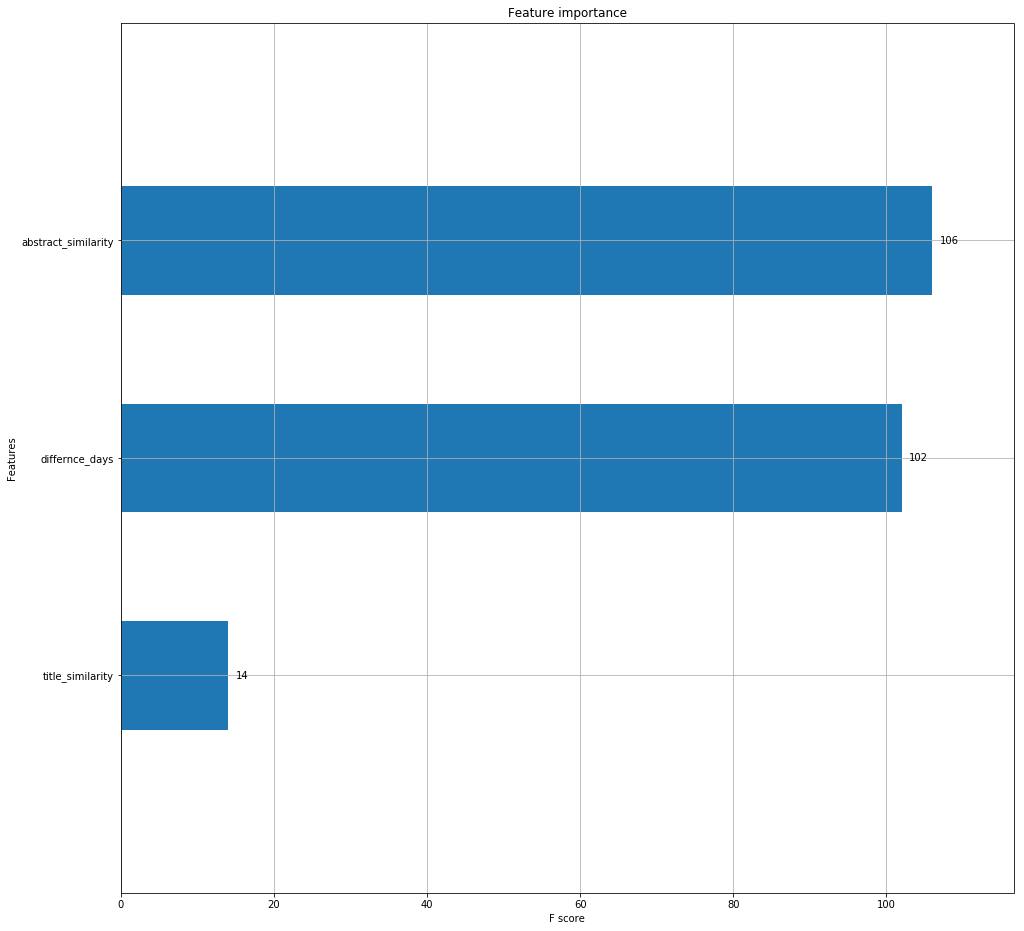

In [21]:
predictors = combined_data_train[16].select_dtypes(['float64', 'int64', 'uint8']).columns.drop('is_reference').drop('pmid_1')


y_train = combined_data_train[16].is_reference

xgb_params = {
    'eta': 0.3,
    'max_depth': 5,
    'subsample': 0.6,
    'colsample_bytree': 1,
    'lambda': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 0
}

dtrain = xgb.DMatrix(data=combined_data_train[16][predictors], label= y_train)


num_rounds = 10000

model_cv = xgb.cv(xgb_params, dtrain, num_rounds, nfold=10, early_stopping_rounds=20, verbose_eval=1)
model = xgb.train(xgb_params, dtrain, num_boost_round = 44)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
xgb.plot_importance(model, height=0.5, ax=ax)

In [23]:
test = pd.read_csv('/home/infoobjects/Desktop/Innoplexus/test.csv')
information_test = pd.read_csv('/home/infoobjects/Desktop/Innoplexus/information_test.csv',delimiter='\t')

test_joined = test.join(information_test.set_index('pmid'),on='pmid').drop(['full_Text','author_str','set'], 1)



In [25]:
test_set_numbers = list(information_test.set.value_counts().index)
test_set_numbers

[9, 4, 10, 17, 15, 19, 1, 11, 7]

In [26]:
predictors

Index(['differnce_days', 'title_similarity', 'abstract_similarity'], dtype='object')

In [27]:
test_joined

,pmid,abstract,article_title,pub_date
0,14058267,A technique is described for collecting thorac...,The absorption of oleic acid in the bile fistu...,1963-09-01
1,4550818,F-merogenotes derived from F14 by transduction...,Ordering of Mutant Sites in the Isoleucine-Val...,1972-02-01
2,14222809,Direct electron microscopic evidence is report...,ULTRASTRUCTURE OF ISOLATED KIDNEY MITOCHONDRIA...,1964-11-01
3,4164675,In vitro synthesis of β1C and immune globulins...,β1C and immune globulin formation in vitro by ...,1967-04-01
4,6211173,1. A substantial increase of the initial rate ...,Kinetic mechanism of mitochondrial adenosine t...,1982-01-15
5,4180008,The translational motility of Pseudomonas fluo...,Effect of Respiratory Inhibitors on the Motili...,1969-02-01
6,109833,The ability of microsomal membranes to translo...,Tryptic dissection and reconstitution of trans...,1979-04-01
7,5812469,The two morphologically different constituents...,THE ELASTIC FIBER I. The Separation and Partia...,1969-02-01
8,2959277,We present a model for Ca2+ efflux from vesicl...,A kinetic model for Ca2+ efflux mediated by th...,1987-08-01
9,6646125,We have studied the metabolism of dihydrofolat...,Delayed processing of dihydrofolate reductase ...,1983-10-01


In [ ]:
def get_set_wise_test_data(set_number):
    information_for_this_test_set = information_test[information_test.set == set_number]
    information_for_this_test_set = information_for_this_test_set.head(20)
    information_for_this_test_set.reset_index(drop=True,inplace=True)
    information_for_this_test_set = information_for_this_test_set[['abstract','article_title','pmid','pub_date']]

    return information_for_this_test_set

In [ ]:
data_set_wise_test = {}
for each_set in test_set_numbers:
    data_set_wise_test[each_set] = get_set_wise_test_data(each_set)

In [ ]:
combined_data_test = {}
for each_set in test_set_numbers:
    master_frames = []
    this_set_data = data_set_wise_test[each_set]
    for index,row in this_set_data.iterrows():
        master_frames.append(merging_data_frame(this_set_data.iloc[index],this_set_data.drop(this_set_data.index[[index]])))
    
    combined_df = pd.concat(master_frames,ignore_index=True)
    combined_df.pub_date = pd.to_datetime(combined_df.pub_date)
    combined_df.pub_date_1 = pd.to_datetime(combined_df.pub_date_1)
    combined_df['differnce_days'] = combined_df['pub_date'] - combined_df['pub_date_1']
    combined_df['differnce_days'] = combined_df['differnce_days'] / (np.timedelta64(1, 'D'))
    combined_df = combined_df[combined_df > 0].dropna()
    combined_df.reset_index(drop=True,inplace=True)

    combined_data_train[each_set] = combined_df

In [ ]:
X_test_title = tfidf_vectorizer_title.transform(combined_test_df['article_title'])
X = tfidf_vectorizer_abstract.transform(combined_data_train[16]['abstract'])
def cosine_similarity_abstract_test(row):
    
    index_1 = combined_data_train[16].pmid[combined_data_train[16].pmid == row['pmid']].index.tolist()[0]
    index_2 = combined_data_train[16].pmid[combined_data_train[16].pmid == row['pmid_1']].index.tolist()[0]
    similarity_score = cosine_similarity(X[index_1],X[index_2])
    return similarity_score[0][0]
def cosine_similarity_title_test(row):
    
    index_1 = combined_data_train[16].pmid[combined_data_train[16].pmid == row['pmid']].index.tolist()[0]
    index_2 = combined_data_train[16].pmid[combined_data_train[16].pmid == row['pmid_1']].index.tolist()[0]
    similarity_score = cosine_similarity(X_test_title[index_1],X_test_title[index_2])
    return similarity_score[0][0]

In [24]:
sample_df = combined_data_train[16][combined_data_train[16].is_reference== 1]
sample_df = sample_df[['pmid','pmid_1','is_reference']]
sample_df = sample_df.groupby('pmid')['pmid_1'].apply(list)
sample_df.head()

pmid
1370845    [1691208, 2155917, 2157735, 2159539, 2161866, ...
1691208                                            [6269067]
1847008                                            [2819870]
1850635                                   [2161866, 3404526]
2155917                                   [6097599, 6325492]
Name: pmid_1, dtype: object

In [ ]:
master_frames = []
for index,row in test_joined.iterrows():
    merging_data_frame(test_joined.iloc[index],test_joined.drop(test_joined.index[[index]]))
combined_test_df = pd.concat(master_frames,ignore_index=True)

combined_test_df.pub_date = pd.to_datetime(combined_test_df.pub_date)
combined_test_df.pub_date_1 = pd.to_datetime(combined_test_df.pub_date_1)

combined_test_df['differnce_days'] = combined_test_df['pub_date'] - combined_test_df['pub_date_1']
combined_test_df['differnce_days'] = combined_test_df['differnce_days'] / (np.timedelta64(1, 'D'))

combined_test_df = combined_test_df[combined_test_df > 0].dropna()
combined_test_df.reset_index(drop=True,inplace=True)
combined_test_df['similarity_title'] = combined_test_df.apply(cosine_similarity_title_test,axis=1)
combined_test_df['similarity_abstract'] = combined_test_df.apply(cosine_similarity_abstract_test,axis=1)


combined_test_df.head()

In [ ]:
dtest = xgb.DMatrix(data=combined_test_df[predictors]) #Change  test such that it contains columns = pmid,pmid_1,differnce_days,similarity_abstract,similarity_title

preds = model.predict(dtest) # predicts is_reference



In [ ]:
# if is_reference = 1 , then ?
# for the pmid ,how will we combine all rows with 1 as is_reference to create the target list ref_list ? 

#Compute ref_list
df_sub = pd.DataFrame({'pmid': test['pmid'], 'ref_list': ref_list})

df_sub.to_csv('submission2.csv', index=False)